
Goal right now:
1. write API for calling probes on layers
    done.
2. run probes on pretrained models.
2. implement LEACE 
3. test the utility of the algorithm, post LEACE and pre-LEACE, on each class.
    1. plot the new error - old error, for each class 


1. test that when you have better points for probes.
2. test that if you only run probe post layer `l`, where `l` is the layer that achieves above some probe accuracy
3. 

Using device: cuda
Using device: cuda
X shape: torch.Size([1000, 2])
Covariance of the whitened data:
 tensor([[9.9999e-01, 4.3426e-06],
        [4.3426e-06, 9.9998e-01]], device='cuda:0')


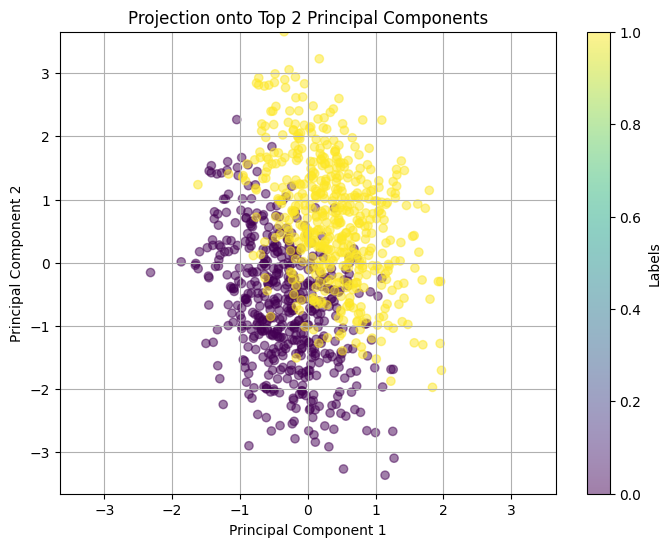

Variance of original data: tensor([1.3752, 0.5668], device='cuda:0')


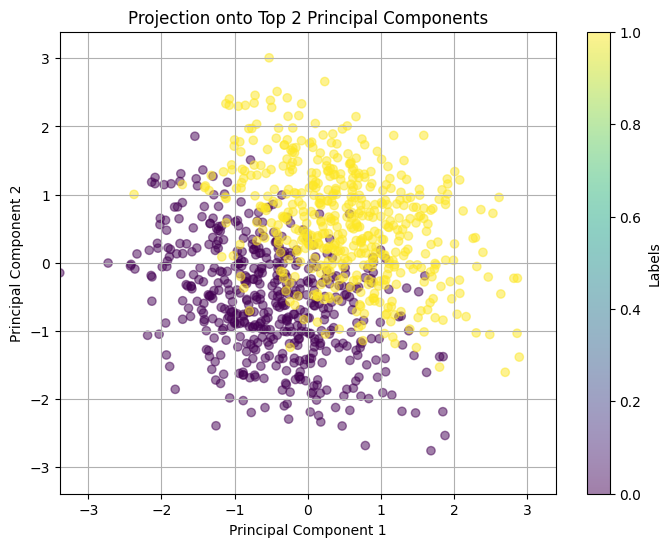

Covariance of whitened data: tensor([[1., 0.],
        [0., 1.]], device='cuda:0')
Variance of original data: tensor([1.0000, 1.0000], device='cuda:0')


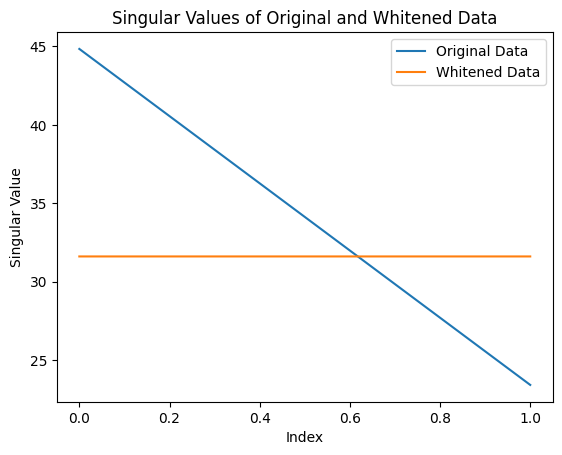

In [1]:
import torch
import matplotlib.pyplot as plt
import torch
from importlib import reload 
from pathlib import Path 

from unlearning.datasets import gaussian 



def check_memory():
    print(f"Memory Allocated: {torch.cuda.memory_allocated() / 1024 ** 2} MB")
    print(f"Max Memory Allocated: {torch.cuda.max_memory_allocated() / 1024 ** 2} MB")
    print(f"Memory Cached: {torch.cuda.memory_reserved() / 1024 ** 2} MB")
    print(f"Max Memory Cached: {torch.cuda.max_memory_reserved() / 1024 ** 2} MB")  


BASE_DIR = Path("/n/home04/rrinberg/data_dir__sneel/Lab/rrinberg/results")

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


from unlearning import probes, leace, plotting
reload(probes)
reload(plotting)
reload(leace)
# Select device: use CUDA if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Create a random dataset with 100 samples and 5 features on the selected device
torch.manual_seed(42)

n_samples = 500
n_features = 2
alpha = 2  # Adjust alpha to change the rate of decay
difference = 1.1

# Generate the dataset and obtain the covariance matrix used
X1, cov_matrix = gaussian.generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device)
X2, cov_matrix = gaussian.generate_powerlaw_gaussian_dataset(n_samples, n_features, alpha=alpha, device=device, mean = difference)

data = torch.cat((X1, X2), dim=0)

labels = torch.zeros(len(data))
labels[len(X1):] = 1

print(f"X shape: {data.shape}")    
# Whiten the dataset
X_white = leace.whiten_data_torch(data)

# Verify that the covariance of the whitened data is approximately the identity matrix
n_samples = X_white.size(0)
cov_whitened = torch.mm(X_white.T, X_white) / (n_samples - 1)
print("Covariance of the whitened data:\n", cov_whitened)

# Optionally, generate some dummy labels (e.g., for binary classes)
#labels = torch.randint(0, 2, (n_samples,), device=device)

# plot original data with top pcs

plotting.plot_top2_pcs_torch(data, labels=labels)
var_orig = torch.var(data, dim=0)
print(f"Variance of original data: {var_orig}")
# plot whitened data
plotting.plot_top2_pcs_torch(X_white, labels=labels)
var_whitened = torch.var(X_white, dim=0)
covar_whitened = torch.cov(X_white.T)
# round covar_whitened to 2 decimal places
covar_whitened = torch.round(covar_whitened * 100) / 100
print(f"Covariance of whitened data: {covar_whitened}")
print(f"Variance of original data: {var_whitened}")

# plot the covariance matrix of the whitened data
U, S, V = torch.svd(data)
U_whitened, S_whitened, V_whitened = torch.svd(X_white)     
plt.plot(S.cpu().numpy(), label='Original Data')
plt.plot(S_whitened.cpu().numpy(), label='Whitened Data')
plt.xlabel('Index')
plt.ylabel('Singular Value')
plt.title('Singular Values of Original and Whitened Data')
plt.legend()
plt.show()


## example model to probe 
(note: probe should attain same level of accuracy as the model itself, as both are linear)

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

# Create a simple synthetic dataset
# We'll create two clusters in 2D space:
# - Cluster for class 0 centered at (-1, -1)
# - Cluster for class 1 centered at (1, 1)
torch.manual_seed(42)

dim = data.shape[1]

# Define the Logistic Regression model
class LogisticRegression(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)  # single output for binary classification

    def forward(self, x):
        # Apply linear transformation followed by a sigmoid activation
        x= x.float()
        return torch.sigmoid(self.linear(x))

# x to float
X = data.float()
labels = labels.float()
model = LogisticRegression(dim)
# model to device
model.to(device)
labels = labels.to(device)
X = X.to(device)
# Define the loss function and the optimizer
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass: compute predicted y by passing X to the model
    outputs = model(X).squeeze()  # squeeze to remove extra dimensions
    loss = criterion(outputs, labels)
    
    # Zero gradients, perform backward pass, and update weights.
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Print loss every 100 epochs
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the trained model
with torch.no_grad():
    predictions = (model(X).squeeze() >= 0.5).float()  # threshold at 0.5 for binary classification
    accuracy = (predictions == labels).float().mean()
    print(f'Accuracy: {accuracy.item() * 100:.2f}%')


Epoch [100/1000], Loss: 0.3723
Epoch [200/1000], Loss: 0.3292
Epoch [300/1000], Loss: 0.3086
Epoch [400/1000], Loss: 0.2970
Epoch [500/1000], Loss: 0.2898
Epoch [600/1000], Loss: 0.2850
Epoch [700/1000], Loss: 0.2816
Epoch [800/1000], Loss: 0.2792
Epoch [900/1000], Loss: 0.2774
Epoch [1000/1000], Loss: 0.2761
Accuracy: 88.50%


In [3]:
# check memory usage 

check_memory()

Memory Allocated: 64.0615234375 MB
Max Memory Allocated: 64.06591796875 MB
Memory Cached: 66.0 MB
Max Memory Cached: 66.0 MB


okay, now that a linear probe is set up, let's test the accuracy on different layers in a real model
# setting up a real model 

Files already downloaded and verified
Files already downloaded and verified


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


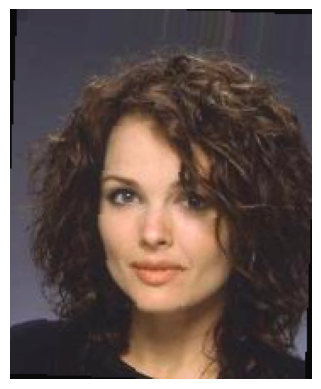

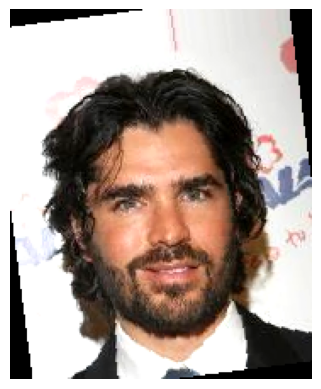

In [4]:

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
import torchvision.datasets as datasets
from unlearning import model_utils
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np 

from torch.utils.data import DataLoader, Subset
import json
import yaml  
def save_yaml(params, filename):
    with open(filename, 'w') as file:
        yaml.dump(params, file)

import pickle 
def save_pickle(params, filename):
    with open(filename, 'wb') as file:
        pickle.dump(params, file)
from pathlib import Path    



DATA_DIR = Path("/n/home04/rrinberg/data_dir/data_to_concept/")

# ========================
# 2. DATA LOADING
# ========================
transform = transforms.Compose([
    #transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),  # Augmentation: Flip images randomly
    transforms.RandomRotation(10),  # Augmentation: Small rotations
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jittering
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

NUM_WORKERS = 4
train_dataset = CelebA(root=DATA_DIR, split="train", transform=transform, download=True, target_type="attr")
val_dataset = CelebA(root=DATA_DIR, split="valid", transform=transform, download=True, target_type="attr")


BATCH_SIZE= 1024
    
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)



from unlearning import plotting
reload(plotting)

pos_index = 0
neg_index = 1

image_ = val_dataset[pos_index][0]
plotting.show_image(image_)

image_ = val_dataset[neg_index][0]
plotting.show_image(image_)

In [5]:
print(f"load model:")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# MPS device
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
print("Using device:", DEVICE)


model = model_utils.load_model(attr_index=1, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)


print(f"evaluate model:")
all_preds, all_labels = model_utils.evaluate(model, val_loader, max_rounds = 5)



vals = [(model_utils.get_TP_TN_FP_FN(i, all_labels, all_preds)[0]) for i in range(40)]



model_layer_count = probes.get_layer_count(model)
print(f"layer count - {model_layer_count}")

# print model accuracy
accuracy = (all_preds == all_labels).float().mean()

#

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


load model:
Using device: cuda


/n/home04/rrinberg/code/data_to_concept_unlearning/unlearning/model_utils.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_without_attr.load_state_dict(torch.load(

evaluate model:


  0%|          | 0/20 [00:00<?, ?it/s]

 25%|██▌       | 5/20 [00:30<01:32,  6.17s/it]

layer count - 10


In [6]:
vals[3]

(tensor(512), tensor(3785), tensor(266), tensor(557))

In [7]:
check_memory()
print(f"model accuracy - {accuracy}")
attribute_index = 20


print(f"vals[{attribute_index} ] = {vals[attribute_index]}")
reload(plotting)
print(f"accuracy - {plotting.compute_precision_recall_acc(vals[attribute_index])}")

Memory Allocated: 154.28564453125 MB
Max Memory Allocated: 8656.4892578125 MB
Memory Cached: 10976.0 MB
Max Memory Cached: 10976.0 MB
model accuracy - 0.9129248261451721
vals[20 ] = (tensor(2166), tensor(2872), tensor(30), tensor(52))
accuracy - (tensor(98.6339), tensor(97.6555), tensor(98.3984))


In [8]:
# get probe accuracy 
#train_labels = train_dataset.attr
val_labels = val_dataset.attr
# attribute names 
attr_names = val_dataset.attr_names
print(f"attribute of interest - {attr_names[attribute_index]}")

positive_attributes = val_labels[:, attribute_index] == 1
negative_attributes = val_labels[:, attribute_index] == 0


N = 1000

pos_indices = torch.where(positive_attributes)[0]
neg_indices = torch.where(negative_attributes)[0]

# shuffle pos_indices
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)


# set up a probe dataset 
print(f"len pos_indices - {len(pos_indices)}")
print(f"len neg_indices - {len(neg_indices)}")
# shuffle neg_indices



/tmp/ipykernel_3804393/1187066193.py:18: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/tmp/ipykernel_3804393/1187066193.py:19: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


attribute of interest - Male
len pos_indices - 8458
len neg_indices - 11409


In [10]:

reload(probes)


pt_count = 650
pos_n  = len(pos_indices)
neg_n  = len(neg_indices)
pt_count = min(pos_n, neg_n, pt_count)

#pt_count = 100

#probe_dataset, labels_ = probes.set_up_probe_dataset(model=model, layer_ind = model_layer_count - 2, pos_points=pos_points[:pt_count], neg_points=neg_points[:pt_count], device=DEVICE)

model_layers = list(range(7, model_layer_count))
probe_accs = []
for layer_ind in model_layers:
    embedding_size = probes.get_embedding_size(model, layer_ind)
    print(f"layer_ind - {layer_ind} ; embedding_size : {embedding_size}")

    probe_acc = probes.mlp_probe(model=model, layer_ind = layer_ind, pos_indices=pos_indices[:pt_count], neg_indices=neg_indices[:pt_count], dataset= val_dataset,device=DEVICE, verbose = True, num_epochs = 750, SGD= False)[0]
    probe_accs.append(probe_acc)
    print(f"probe acc - {probe_acc}")
    print("----")

layer_ind - 7 ; embedding_size : 86016
generating loader from scratch
batching embeddings
Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
generating loader from scratch
batching embeddings
Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
probe_dataset shape: torch.Size([1300, 86016])
using adam:
Epoch [100/750], Loss: 0.6042
Epoch [200/750], Loss: 0.6025
Epoch [300/750], Loss: 0.6012
Epoch [400/750], Loss: 0.5510
Epoch [500/750], Loss: 0.5385
Epoch [600/750], Loss: 0.5385
Epoch [700/750], Loss: 0.5385
Accuracy: 99.46%
probe acc - 99.4615375995636
----
layer_ind - 8 ; embedding_size : 2048
generating loader from scratch
batching embeddings
Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
generating loader from scratch
batching embeddings
Processing batch 1/3
Processing batch 2/3
Processing batch 3/3
probe_dataset shape: torch.Size([1300, 2048])
using adam:
Epoch [100/750], Loss: 0.0177
Epoch [200/750], Loss: 0.0068
Epoch [300/750], Loss: 0.0021

Text(0.5, 1.0, 'Probe accuracy across layers')

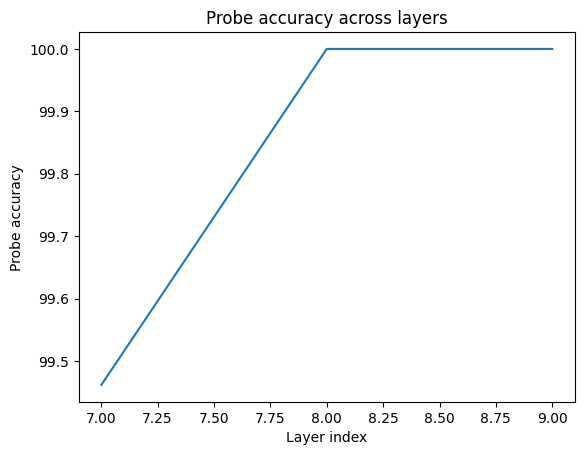

In [12]:
#print probe layer accs
probe_accs = np.array(probe_accs)
plt.plot(model_layers, probe_accs)
plt.xlabel("Layer index")
plt.ylabel("Probe accuracy")
plt.title("Probe accuracy across layers")
#plt.show()

# test the contrastive examples probe-ability 
(should be lower than the general probe-ability.)
## do this for each class, and then also just do it for nearby embedding points, using KNN

In [13]:
if False:
    layer_ind = 0

    probe_tup = probes.linear_probe(model=model, layer_ind = layer_ind, pos_points=pos_points[:pt_count], neg_points=neg_points[:pt_count], device=DEVICE)

    probe_acc= probe_tup[0]
    print(f"probe acc - {probe_acc}")

In [14]:
check_memory()

Memory Allocated: 1548.64111328125 MB
Max Memory Allocated: 8656.4892578125 MB
Memory Cached: 10990.0 MB
Max Memory Cached: 10990.0 MB


In [15]:
layer_ind = 8

In [16]:

positive_attributes = val_labels[:, attribute_index] == 1
negative_attributes = val_labels[:, attribute_index] == 0
reload(probes)

N = 1000

pos_indices = torch.where(positive_attributes)[0]
neg_indices = torch.where(negative_attributes)[0]

# shuffle pos_indices
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)



probe_dataset, probe_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices[:N], neg_indices=neg_indices[:N], dataset = val_dataset, device = device, verbose = True)

print(f"probe_dataset - {probe_dataset.shape}")
print(f"probe_labels - {probe_labels.shape}")

generating loader from scratch
batching embeddings


/tmp/ipykernel_3804393/3454203930.py:11: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/tmp/ipykernel_3804393/3454203930.py:12: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
probe_dataset - torch.Size([2000, 2048])
probe_labels - torch.Size([2000])


In [17]:
check_memory()

probe_dataset[0].shape

Memory Allocated: 2204.89111328125 MB
Max Memory Allocated: 8656.4892578125 MB
Memory Cached: 10990.0 MB
Max Memory Cached: 10990.0 MB


torch.Size([2048])

In [18]:
# 
reload(probes )

import faiss
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import os


class ImageSearch:
    def __init__(self, model, layer_ind, embedding_size=2048):
        self.model = model 
        self.layer_ind = layer_ind

        self.index = faiss.IndexFlatL2(embedding_size)
        self.image_indices = []

        # Pre-trained ResNet50 for embedding extraction
        self.model.eval()

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def add_embedding(self, embedding, image_index):
        
        #embedding = np.array(embedding).astype('float32').reshape(1, -1)
        embedding = embedding.float().view(1, -1).cpu()
        self.index.add(embedding)
        self.image_indices.append(image_index)


    def search_embedding(self, query_embedding, top_k=5):
        
        #query_embedding = query_embedding.astype('float32').reshape(1, -1)
        query_embedding = query_embedding.float().view(1, -1).cpu()
        distances, indices = self.index.search(query_embedding, top_k)

        results = [(self.image_indices[idx], distances[0][i]) for i, idx in enumerate(indices[0])]
        return results


print(f"model_layer_count- {model_layer_count}")
print(f"init")

embedding_size = probes.get_embedding_size(model, layer_ind = layer_ind)

print(f"model embeddinging size {embedding_size}")
# compute the embedding size 
search_engine = ImageSearch(model = model, layer_ind = layer_ind, embedding_size=embedding_size)


model_layer_count- 10
init
model embeddinging size 2048


In [19]:
# embed into it the concept 

N_ = len(probe_dataset)
for ii, (embedding, embedding_label) in enumerate(zip(probe_dataset, probe_labels)):
    if embedding_label == 0:
        continue
    if ii % (N//10) == 0:
        print(f"embedding {ii}/{N_}")
    search_engine.add_embedding(embedding = embedding, image_index = ii)
# add an embedding



embedding 0/2000
embedding 100/2000
embedding 200/2000
embedding 300/2000
embedding 400/2000
embedding 500/2000
embedding 600/2000
embedding 700/2000
embedding 800/2000
embedding 900/2000


### test embedding search space

embedding 1000/2000
embedding 1100/2000
embedding 1200/2000
embedding 1300/2000
embedding 1400/2000
embedding 1500/2000
embedding 1600/2000
embedding 1700/2000
embedding 1800/2000
embedding 1900/2000


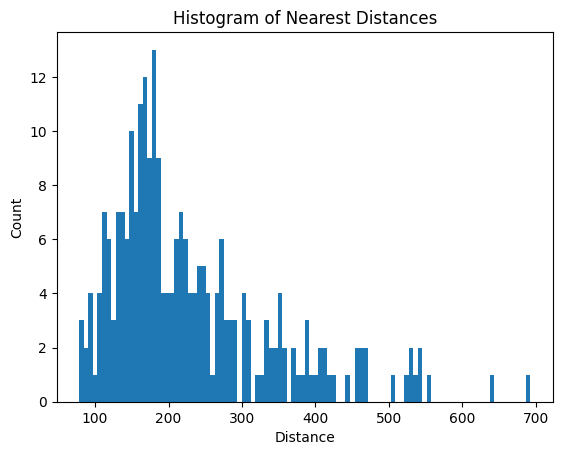

In [20]:
# search for the first image 
embedding = probe_dataset[-1]
search_engine.search_embedding(query_embedding = embedding, top_k=5)
from collections import defaultdict
seen = set()
nearest_distances = defaultdict(lambda: 1000000)

for ii, (embedding, embedding_label) in enumerate(zip(probe_dataset, probe_labels)):
    if embedding_label == 1:
        continue
    if ii % (N//10) == 0:
        print(f"embedding {ii}/{N_}")
    
    results = search_engine.search_embedding(query_embedding = embedding, top_k=5)
    for (ind, dist) in results:
        if ind == ii:
            continue
        nearest_distances[ind] = min(nearest_distances[ind], dist)

# plot hist of nearest_distances

plt.hist(list(nearest_distances.values()), bins=100)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Histogram of Nearest Distances")
plt.show()

### compute these distances over all val points

In [21]:
check_memory()
# clear memory
torch.cuda.empty_cache()
# gc 
import gc
gc.collect()
check_memory()


Memory Allocated: 2205.21923828125 MB
Max Memory Allocated: 8656.4892578125 MB
Memory Cached: 10992.0 MB
Max Memory Cached: 10992.0 MB
Memory Allocated: 2205.21923828125 MB
Max Memory Allocated: 8656.4892578125 MB
Memory Cached: 5548.0 MB
Max Memory Cached: 10992.0 MB


In [22]:
all_neg_indices = torch.where(negative_attributes)[0]

len(all_neg_indices)

positive_centroid = torch.mean(probe_dataset[probe_labels == 1], dim=0)
positive_centroid.shape
positive_centroid.device

device(type='cpu')

In [23]:
sum(probe_labels == 1)

tensor(1000)

In [24]:
reload(probes)
nearest_distances = defaultdict(lambda: 1000000)
distance_to_centroid = {}

all_neg_indices = torch.where(negative_attributes)[0]
# shuffle 
all_neg_indices = np.array(all_neg_indices)
np.random.shuffle(all_neg_indices)

indices_to_check =all_neg_indices[:4_500]

for neg_ii, neg_image_index in enumerate(indices_to_check):
    if neg_ii % (len(indices_to_check)//10) == 0:
        print(f"embedding {neg_ii}/{len(indices_to_check)}")
    
    image = val_dataset[neg_image_index][0]
    image = image.unsqueeze(0).to(device)  # Add batch dimension

    embedding = probes.get_flattened_embedding(model, layer_ind = layer_ind, x = image)
    results = search_engine.search_embedding(query_embedding = embedding, top_k=3)
    min_index = np.argmin([dist for (pos_ind, dist) in results])    
    pos_ind, min_dist = results[min_index]
    nearest_distances[neg_image_index] = min_dist
    if False:
        for (pos_ind, dist) in results:
            if ind == neg_ii:
                continue
            existing_dist = nearest_distances[neg_image_index]
            nearest_distances[neg_image_index] = min(existing_dist, dist)

    # report distance to centroid
    distance_to_centroid[neg_image_index] = torch.norm(positive_centroid - embedding.cpu()).item()

embedding 0/4500


/tmp/ipykernel_3804393/3534759443.py:7: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  all_neg_indices = np.array(all_neg_indices)


embedding 450/4500
embedding 900/4500
embedding 1350/4500
embedding 1800/4500
embedding 2250/4500
embedding 2700/4500
embedding 3150/4500
embedding 3600/4500
embedding 4050/4500


## todo : create a function that computes the `ordered_nearest_distances` (using centroid), efficiently

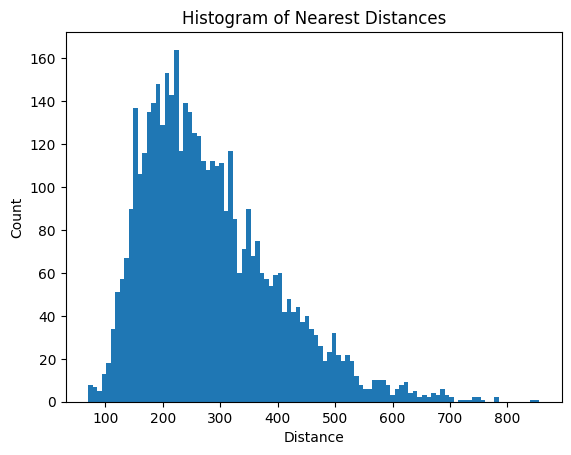

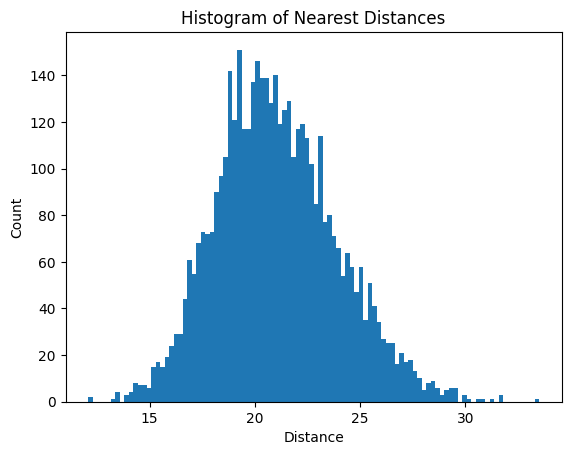

4500
pearson_corr between ranking of nearest distances to centroid distance - 0.9867618944216097


In [25]:
# plot nearest_distances
# plot hist of nearest_distances

plt.hist(list(nearest_distances.values()), bins=100)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Histogram of Nearest Distances")
plt.show()


# plot distance_to_centroid
plt.hist(list(distance_to_centroid.values()), bins=100)
plt.xlabel("Distance")
plt.ylabel("Count")
plt.title("Histogram of Nearest Distances")
plt.show()


# order nearest_distances
ordered_nearest_distances = sorted(nearest_distances.items(), key=lambda x: x[1])
# order distance_to_centroid
ordered_distance_to_centroid = sorted(distance_to_centroid.items(), key=lambda x: x[1])
length = min(len(ordered_nearest_distances), len(ordered_distance_to_centroid))

print(length)
# print the pearson rank correlation between the two
import scipy.stats as stats
pearson_corr, _ = stats.pearsonr([x[1] for x in ordered_nearest_distances[:length]], [x[1] for x in ordered_distance_to_centroid[:length]])
print(f"pearson_corr between ranking of nearest distances to centroid distance - {pearson_corr}")


## observe that picking 1-NN embedding distance to any point, or just to the center has a very similar ranking: 

pearson_corr between ranking of nearest distances to centroid distance - 0.9843334185769756


In [26]:
layer_ind 

8

In [27]:
#ordered_nearest_distances
    

[(np.int64(17551), np.float32(70.15332)),
 (np.int64(14547), np.float32(70.286415)),
 (np.int64(62), np.float32(70.51085)),
 (np.int64(17887), np.float32(75.47867)),
 (np.int64(13306), np.float32(75.97005)),
 (np.int64(14480), np.float32(76.261406)),
 (np.int64(14881), np.float32(76.62833)),
 (np.int64(12590), np.float32(77.6897)),
 (np.int64(19381), np.float32(78.99074)),
 (np.int64(16323), np.float32(80.40157)),
 (np.int64(8492), np.float32(80.79503)),
 (np.int64(2445), np.float32(82.96274)),
 (np.int64(8204), np.float32(84.41289)),
 (np.int64(7934), np.float32(84.71511)),
 (np.int64(17603), np.float32(84.78178)),
 (np.int64(18334), np.float32(88.91447)),
 (np.int64(4784), np.float32(88.9894)),
 (np.int64(17973), np.float32(90.65398)),
 (np.int64(323), np.float32(92.00763)),
 (np.int64(146), np.float32(92.58685)),
 (np.int64(16056), np.float32(94.25255)),
 (np.int64(9198), np.float32(94.51133)),
 (np.int64(16178), np.float32(96.16153)),
 (np.int64(12506), np.float32(96.473305)),
 (np

In [28]:
# pick top 1000 of 
N = len(pos_indices)
#N = 500# 1000
print(f"N - {N}")
N = min(N, len(ordered_nearest_distances), 1000 )

closest_neg_indices = [int(ordered_nearest_distances[i][0]) for i in range(N)]
closest_neg_indices = np.array(closest_neg_indices)


## base probe
#shuffle neg_indices, choose 1000 random points from neg_indices
neg_indices_normal = np.random.choice(all_neg_indices, size=N, replace=False)


normal_probe_dataset, normal_probe_dataset_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices, neg_indices=neg_indices_normal, dataset =val_dataset, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), verbose = True)



# create probe dataset of these closest_neg_attributes, and positive images

closest_probe_dataset, closest_probe_dataset_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices, neg_indices=closest_neg_indices, dataset =val_dataset, device = torch.device("cuda" if torch.cuda.is_available() else "cpu"), verbose = True)
    
#val_dataset[0][0].shape



N - 8458
generating loader from scratch
batching embeddings


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Processing batch 1/34
Processing batch 5/34
Processing batch 9/34
Processing batch 13/34
Processing batch 17/34
Processing batch 21/34
Processing batch 25/34
Processing batch 29/34
Processing batch 33/34
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/34
Processing batch 5/34
Processing batch 9/34
Processing batch 13/34
Processing batch 17/34
Processing batch 21/34
Processing batch 25/34
Processing batch 29/34
Processing batch 33/34
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4


In [29]:
# test probe
reload(probes)


print(f"Probe on random vals")

linear_probe_random = probes.test_linear_probe(normal_probe_dataset, normal_probe_dataset_labels, model, num_epochs= 1000, verbose= False)
MLP_probe_random = probes.test_MLP_probe(normal_probe_dataset, normal_probe_dataset_labels, model, num_epochs= 1000, verbose= False)

print(f"\tlinear_probe_random_acc - {linear_probe_random[0]}")
print(f"\tMLP_probe_random_acc - {MLP_probe_random[0]}")


print(f"Probe on closest vals")
linear_probe_closest = probes.test_linear_probe(closest_probe_dataset, closest_probe_dataset_labels, model, num_epochs= 1000, verbose= False)

MLP_probe_closest = probes.test_MLP_probe(closest_probe_dataset, closest_probe_dataset_labels, model, num_epochs= 1000, verbose= False)

print(f"\tlinear_probe_closest_acc - {linear_probe_closest[0]}")
print(f"\tMLP_probe_closest_acc - {MLP_probe_closest[0]}")


Probe on random vals
using adam:


using adam:
	linear_probe_random_acc - 99.23874139785767
	MLP_probe_random_acc - 99.9471366405487
Probe on closest vals
using adam:
using adam:
	linear_probe_closest_acc - 98.28716516494751
	MLP_probe_closest_acc - 99.88369941711426


In [30]:
# now test probe accuracy with better contrastive examples chosen

embedding_1, image_index_1 = probe_dataset[0], 0
search_engine.add_embedding(embedding = embedding_1, image_index = image_index_1)

if False:
    search_engine = ImageSearch()
    search_engine.load_images_from_directory('path_to_your_image_folder')

    results = search_engine.search_image('path_to_query_image.jpg', top_k=3)
    for path, dist in results:
        print(f"Matched Image: {path}, Distance: {dist}")


## If we minimize probe accuracy on train set, how does that effect the probe accuracy on the val set?

In [31]:
for i, attr_name in enumerate(train_dataset.attr_names):
    print(f"attribute {i} - {attr_name}")


model_attribute_ind = 0
probe_attribute_index = 13


print(f"attribute = {train_dataset.attr_names[attribute_index]}")
model = model_utils.load_model(attr_index=model_attribute_ind, models_dir=BASE_DIR / "models_without_labels__multiple", DEVICE = DEVICE)

layer_count = probes.get_layer_count(model)
layer_ind = layer_count - 2


attribute 0 - 5_o_Clock_Shadow
attribute 1 - Arched_Eyebrows
attribute 2 - Attractive
attribute 3 - Bags_Under_Eyes
attribute 4 - Bald
attribute 5 - Bangs
attribute 6 - Big_Lips
attribute 7 - Big_Nose
attribute 8 - Black_Hair
attribute 9 - Blond_Hair
attribute 10 - Blurry
attribute 11 - Brown_Hair
attribute 12 - Bushy_Eyebrows
attribute 13 - Chubby
attribute 14 - Double_Chin
attribute 15 - Eyeglasses
attribute 16 - Goatee
attribute 17 - Gray_Hair
attribute 18 - Heavy_Makeup
attribute 19 - High_Cheekbones
attribute 20 - Male
attribute 21 - Mouth_Slightly_Open
attribute 22 - Mustache
attribute 23 - Narrow_Eyes
attribute 24 - No_Beard
attribute 25 - Oval_Face
attribute 26 - Pale_Skin
attribute 27 - Pointy_Nose
attribute 28 - Receding_Hairline
attribute 29 - Rosy_Cheeks
attribute 30 - Sideburns
attribute 31 - Smiling
attribute 32 - Straight_Hair
attribute 33 - Wavy_Hair
attribute 34 - Wearing_Earrings
attribute 35 - Wearing_Hat
attribute 36 - Wearing_Lipstick
attribute 37 - Wearing_Necklac

/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/n/home04/rrinberg/code/data_to_concept_unlearning/unlearning/model_utils.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.m

evaluate model:


 25%|██▌       | 5/20 [00:30<01:32,  6.16s/it]


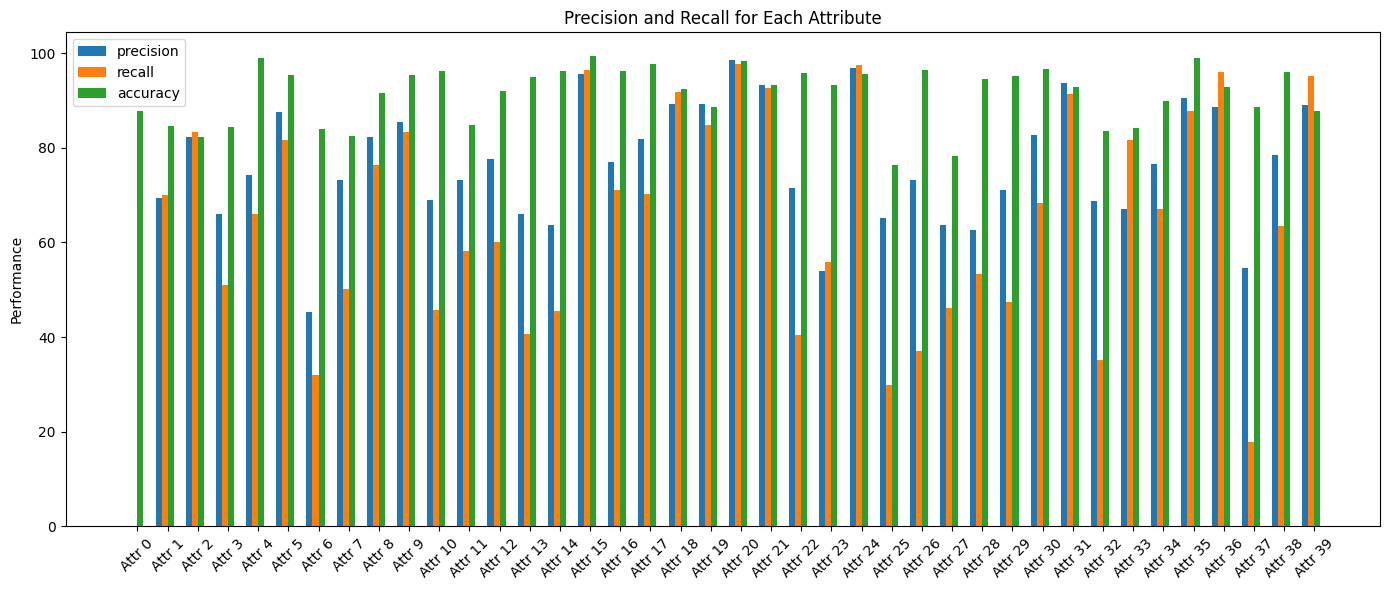

In [32]:
# evaluate model
print(f"evaluate model:")
all_preds, all_labels = model_utils.evaluate(model, val_loader, max_rounds = 5)
# plot bars
vals = [(model_utils.get_TP_TN_FP_FN(i, all_labels, all_preds)[0]) for i in range(40)]
vals = np.array(vals)

reload(plotting)
plotting.generate_precision_recall_chart(vals)

In [33]:
# okay let's run GA on the closest_neg_indices, from the train set
reload(probes)

train_dataset
train_labels = train_dataset.attr
#print(f"train_dataset - {train_dataset}")
print(f"train_labels - {train_labels.shape}")

# 1. construct probe dataset for train_dataset 
# 2. make a quick function for compute "closest_counterfactuals "

print(f"attribute of interest - {attr_names[attribute_index]}")


positive_attributes = train_labels[:, probe_attribute_index] == 1
negative_attributes = train_labels[:, probe_attribute_index] == 0
pos_indices = torch.where(positive_attributes)[0]
neg_indices = torch.where(negative_attributes)[0]


N = min(2000, len(pos_indices), len(neg_indices))


val_positive_attributes = val_labels[:, probe_attribute_index] == 1
val_negative_attributes = val_labels[:, probe_attribute_index] == 0
val_pos_indices = torch.where(val_positive_attributes)[0]
val_neg_indices = torch.where(val_negative_attributes)[0]

val_N = min(1000, len(val_pos_indices), len(val_neg_indices))
# shuffle pos_indices
np.random.shuffle(pos_indices)
np.random.shuffle(neg_indices)

# shuffle pos_indices
np.random.shuffle(val_pos_indices)
np.random.shuffle(val_neg_indices)

print(f"pos indices - {len(pos_indices)}")
print(f"neg indices - {len(neg_indices)}")

embedding_size = probes.get_embedding_size(model, layer_ind = layer_ind)
print(f"layer: { layer_ind} ; embedding size: {embedding_size}")

print(f"compute train probe set:")

probe_dataset, probe_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=pos_indices[:N], neg_indices=neg_indices[:N], dataset = train_dataset, device = device, verbose = True)

print(f"compute val probe set:")
val_probe_dataset, val_probe_labels = probes.set_up_probe_dataset(model, layer_ind, pos_indices=val_pos_indices[:val_N], neg_indices=val_neg_indices[:val_N], dataset = val_dataset, device = device, verbose = True)


train_labels - torch.Size([162770, 40])
attribute of interest - Male


/tmp/ipykernel_3804393/2049898676.py:31: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(pos_indices)
/tmp/ipykernel_3804393/2049898676.py:32: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(neg_indices)


pos indices - 9389
neg indices - 153381
layer: 8 ; embedding size: 2048
compute train probe set:
generating loader from scratch
batching embeddings


/tmp/ipykernel_3804393/2049898676.py:35: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(val_pos_indices)
/tmp/ipykernel_3804393/2049898676.py:36: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(val_neg_indices)
/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get 

Processing batch 1/8
Processing batch 2/8
Processing batch 3/8
Processing batch 4/8
Processing batch 5/8
Processing batch 6/8
Processing batch 7/8
Processing batch 8/8
generating loader from scratch
batching embeddings
Processing batch 1/8
Processing batch 2/8
Processing batch 3/8
Processing batch 4/8
Processing batch 5/8
Processing batch 6/8
Processing batch 7/8
Processing batch 8/8
compute val probe set:
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4


In [34]:
shapes = set()
for i in range(100):
    shapes.add(train_dataset[i][0].shape)

print(shapes)


{torch.Size([3, 218, 178])}


In [35]:
reload(probes)
for l_ in range(layer_count):
    input_dummy_shape =torch.Size([1, 3, 218, 178])
    #print(input_dummy_shape)

    embedding_size = probes.get_embedding_size(model, l_, input_dummy_shape=input_dummy_shape)
    print(f"layer: {l_} ; embedding size: \t\t{embedding_size}")

        
    embedding_size = probes.get_embedding_size(model, l_, )
    print(f"layer: {l_} ; default embedding size: \t{embedding_size}")


layer: 0 ; embedding size: 		620864
layer: 0 ; default embedding size: 	620864
layer: 1 ; embedding size: 		620864
layer: 1 ; default embedding size: 	620864
layer: 2 ; embedding size: 		620864
layer: 2 ; default embedding size: 	620864
layer: 3 ; embedding size: 		158400
layer: 3 ; default embedding size: 	158400
layer: 4 ; embedding size: 		633600
layer: 4 ; default embedding size: 	633600
layer: 5 ; embedding size: 		329728
layer: 5 ; default embedding size: 	329728
layer: 6 ; embedding size: 		172032
layer: 6 ; default embedding size: 	172032
layer: 7 ; embedding size: 		86016
layer: 7 ; default embedding size: 	86016
layer: 8 ; embedding size: 		2048
layer: 8 ; default embedding size: 	2048
layer: 9 ; embedding size: 		40
layer: 9 ; default embedding size: 	40


In [39]:
pt_count= 1000
reload(probes)
#for layer_ind in [0,8,9]:


pos_subset = Subset(train_dataset, pos_indices)
pos_loader = DataLoader(pos_subset, batch_size=256, shuffle=False, num_workers=4)
neg_subset = Subset(train_dataset, neg_indices)
neg_loader = DataLoader(neg_subset, batch_size=256, shuffle=False, num_workers=4)

loaders = (pos_loader, neg_loader)
loaders= None
probe_accs= []
layers_ = [0,4, 7,8,9]
for layer_ind in layers_:
    embedding_size = probes.get_embedding_size(model, layer_ind)
    print(f"layer_ind - {layer_ind} ; embedding_size : {embedding_size}")

    probe_acc = probes.mlp_probe(model=model, layer_ind = layer_ind, pos_indices=pos_indices[:pt_count], neg_indices=neg_indices[:pt_count], dataset= train_dataset,device=DEVICE, verbose = True, num_epochs = 1000, loaders=loaders)[0]
    print(f"probe acc - {probe_acc}")
    probe_accs.append(probe_acc)
    print("----")

layer_ind - 0 ; embedding_size : 620864
generating loader from scratch
batching embeddings


/n/holylabs/LABS/vadhan_lab/Lab/rrinberg/envs/unlearning_3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
probe_dataset shape: torch.Size([2000, 620864])
using adam:
Epoch [100/1000], Loss: 13.3473
Epoch [200/1000], Loss: 5.9615
Epoch [300/1000], Loss: 5.9544
Epoch [400/1000], Loss: 5.9543
Epoch [500/1000], Loss: 5.9543
Epoch [600/1000], Loss: 5.9542
Epoch [700/1000], Loss: 5.9542
Epoch [800/1000], Loss: 5.9541
Epoch [900/1000], Loss: 5.9541
Epoch [1000/1000], Loss: 5.9541
Accuracy: 94.00%
probe acc - 94.0000057220459
----
layer_ind - 4 ; embedding_size : 633600
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
generating loader from scratch
batching embeddings
Processing batch 1/4
Processing batch 2/4
Processing batch 3/4
Processing batch 4/4
probe_dataset shape: torch.Size([2000, 633600])


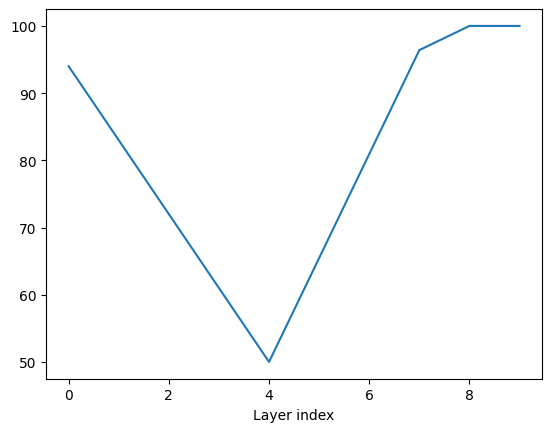

In [41]:
# plot probe accs
plt.plot(layers_, probe_accs)
plt.xlabel("Layer index")
plt.show()

In [40]:
check_memory()

Memory Allocated: 9989.53271484375 MB
Max Memory Allocated: 18489.71630859375 MB
Memory Cached: 33750.0 MB
Max Memory Cached: 33750.0 MB


In [37]:
# train MLP on probe_dataset
mlp_probe = probes.test_MLP_probe(probe_dataset= probe_dataset, probe_labels = probe_labels, model= model, num_epochs= 1000, verbose= True)
# (probe_acc, probe_dataset, probe_labels, probe_model)
mlp_probe

linear_probe = probes.test_linear_probe(probe_dataset= probe_dataset, probe_labels = probe_labels, model= model, num_epochs= 1000, verbose= True)

using adam:
Epoch [100/1000], Loss: 0.2334
Epoch [200/1000], Loss: 0.1795
Epoch [300/1000], Loss: 0.1312
Epoch [400/1000], Loss: 0.0978
Epoch [500/1000], Loss: 0.0778
Epoch [600/1000], Loss: 0.0528
Epoch [700/1000], Loss: 0.0395
Epoch [800/1000], Loss: 0.0296
Epoch [900/1000], Loss: 0.0226
Epoch [1000/1000], Loss: 0.0166
Accuracy: 99.93%
using adam:
Epoch [100/1000], Loss: 0.2533
Epoch [200/1000], Loss: 0.2406
Epoch [300/1000], Loss: 0.2317
Epoch [400/1000], Loss: 0.2236
Epoch [500/1000], Loss: 0.2161
Epoch [600/1000], Loss: 0.2089
Epoch [700/1000], Loss: 0.2020
Epoch [800/1000], Loss: 0.1955
Epoch [900/1000], Loss: 0.1893
Epoch [1000/1000], Loss: 0.1833
Accuracy: 92.78%


# Let's do iterative GA on the probes

In [43]:
# copy the model
import copy
original_model = copy.deepcopy(model)

In [57]:
from torch.utils.data import Dataset

class CustomLabeledDataset(Dataset):
    def __init__(self, base_dataset, indices, custom_labels):
        self.base_dataset = base_dataset
        self.indices = indices
        self.custom_labels = custom_labels

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        data, _ = self.base_dataset[self.indices[idx]]  # Ignore original label
        label = self.custom_labels[idx]
        return data, label
    

pt_count = min(len(pos_indices), len(neg_indices), pt_count)
probe_indices = torch.concat((pos_indices[:pt_count], neg_indices[:pt_count]), dim=0)
probe_labels = torch.concat([torch.ones(pt_count), torch.zeros(pt_count)], dim=0)

probe_dataset = CustomLabeledDataset(
    base_dataset=train_dataset,
    indices=probe_indices,
    custom_labels=probe_labels
)

# create val probe dataset :
val_probe_indices = torch.concat((val_pos_indices[:val_N], val_neg_indices[:val_N]), dim=0)
val_probe_labels = torch.concat([torch.ones(val_N), torch.zeros(val_N)], dim=0)
val_probe_dataset = CustomLabeledDataset(
    base_dataset=val_dataset,
    indices=val_probe_indices,
    custom_labels=val_probe_labels
)

from torch.utils.data import DataLoader

probe_loader = DataLoader(probe_dataset, batch_size=64, shuffle=True, num_workers=4)



In [55]:
# 
### set up an MLP probe
embedding_size = probes.get_embedding_size(model, layer_ind = layer_ind)
probe_model = probes.MLP(input_dim=embedding_size, hidden_size=128, output_size=2)
probe_optimizer = optim.Adam(probe_model.parameters(), lr=0.001)

#train_model(model, dataset, labels, device = device, num_epochs = num_epochs, verbose=verbose, SGD=SGD)

for images, labels in probe_loader:
    print(f"images shape - {images.shape}")
    print(f"labels shape - {labels.shape}")
    # get embeddings
    embeddings = []
    for image in images: # TODO : create a batched version of this
        embedding = probes.get_flattened_embedding(model, layer_ind = layer_ind, x = image.unsqueeze(0).to(device))
        embeddings.append(embedding)
    # train the probe model
    embeddings = torch.cat(embeddings, dim=0)
    print(f"embeddings shape - {embeddings.shape}")

    # train the probe model
    
    probe_model.train()
    probe_model.to(device)
    embeddings = embeddings.to(device)
    labels = labels.to(device)
    probe_optimizer.zero_grad()
    outputs = probe_model(embeddings)
    loss = F.cross_entropy(outputs, labels.long())
    loss.backward()
    probe_optimizer.step()
    print(f"loss - {loss.item()}")
    
    break 
        # Your training or probing logic here
#probe_dataset.custom_labels

tensor([1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1.,
        1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0.,
        1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

In [44]:
#probe_dataset, probe_labels
#model
verbose = True


probe_subset = Subset(train_dataset, indices)
# get get labels 
probe_loader = DataLoader(probe_subset, batch_size=256, shuffle=False, num_workers=4)


    
if False:

    criterion = nn.BCELoss()  # Binary Cross Entropy Loss
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        # Forward pass: compute predicted y by passing X to the model
        outputs = model(X).squeeze()  

        loss = criterion(outputs, labels)

        # Invert loss for gradient ascent
        ascent_loss = -loss
        
        # Zero gradients, backward pass, optimizer step
        optimizer.zero_grad()
        ascent_loss.backward()
        optimizer.step()

        
        # Print loss every 100 epochs
        if verbose and (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    # Evaluate the trained model
    with torch.no_grad():
        predictions = (model(X).squeeze() >= 0.5).float()  # threshold at 0.5 for binary classification
        accuracy = (predictions == labels).float().mean()
        if verbose:
            print(f'Accuracy: {accuracy.item() * 100:.2f}%')



## Can we project GA-steps onto GD steps for a different loss function - plot val-probe accuracy